In [94]:
import matplotlib.pyplot as plt
import numpy as np
import helpers as h
import pandas as pd
import re
import os

### Create folder for images

In [199]:
%mkdir img

### Load evaluations

In [2]:
FOLDER_PATH = './test_set_evaluation'
FF_PATH = f"{FOLDER_PATH}/ff_test_set_eval.txt"
CONV_PATH = f"{FOLDER_PATH}/conv_test_set_eval.txt"

In [3]:
with open(FF_PATH,'r') as f:
    ff_evaluations = f.readlines()[:-1]
with open(CONV_PATH, 'r') as f:
    conv_evaluations = f.readlines()[:-1]

### Load experiment names

In [4]:
grab_experiment_name = lambda s: re.findall('\./experiments/(.*)/experiment_output.json\n', s)[0]

In [5]:
ff_experiment_names = [grab_experiment_name(line) for line in ff_evaluations if './experiments/ff_' in line]

In [6]:
conv_experiment_names = [grab_experiment_name(line) for line in conv_evaluations if './experiments/conv_' in line]

### Load micro-averages

In [7]:
%%bash
cat test_set_evaluation/ff_test_set_eval.txt | grep "Micro-Average.*$" > ./test_set_evaluation/ff_micro_averages
cat test_set_evaluation/conv_test_set_eval.txt | grep "Micro-Average.*$" > ./test_set_evaluation/conv_micro_averages

In [8]:
with open(f'{FOLDER_PATH}/ff_micro_averages', 'r') as f:
    ff_micro_averages = f.readlines()
with open(f'{FOLDER_PATH}/conv_micro_averages', 'r') as f:
    conv_micro_averages = f.readlines()

In [9]:
assert len(ff_micro_averages) == 3*len(ff_experiment_names)
assert len(conv_micro_averages) == 3*len(conv_experiment_names)

In [74]:
def process_micro_average_line(line):
    _ = line.split()[1:]
    prf1 = (float(_[1]), float(_[3]), float(_[5]))
    return prf1

In [75]:
def generate_average_prf1(experiment_names, averages):
    g_averages = iter(averages)
    output = {}
    for name in experiment_names:
        _all, _explicit, _nonexplicit = next(g_averages), \
                                        next(g_averages), \
                                        next(g_averages)
        d = {}
        d['all'] = process_micro_average_line(_all)
        d['explicit'] = process_micro_average_line(_explicit)
        d['non_explicit'] = process_micro_average_line(_nonexplicit)
        output[name] = d
    return output

In [76]:
ff_average_dict = generate_average_prf1(ff_experiment_names, ff_micro_averages)

In [78]:
conv_average_dict = generate_average_prf1(conv_experiment_names, conv_micro_averages)

### Create results tables

In [79]:
layer_conditions = h.load_pickle('hyperparameters/layer_conditions.pkl')

In [80]:
find_layer_condition = lambda layers: [cond for cond, sizes in layer_conditions.items() if layers in sizes][0]

In [81]:
grab_layers = lambda s: re.findall('layers_(.*)_large', s)[0]
uses_dropout = lambda s: 'dropout0.5' in s

#### Feedforward results

In [82]:
ff_results = pd.DataFrame()

In [83]:
ff_results['experiment_name'] = ff_experiment_names

In [84]:
ff_results['dropout'] = ff_results.experiment_name.apply(uses_dropout)

In [85]:
ff_results['layers'] = ff_results.experiment_name.apply(grab_layers)

In [86]:
ff_results['layer_condition'] = ff_results.layers.apply(lambda l: [int(x) for x in l.split('_')]).apply(find_layer_condition)

In [87]:
ff_results['all_precision'] = ff_results.experiment_name.apply(lambda name: ff_average_dict[name]['all'][0])
ff_results['all_recall'] = ff_results.experiment_name.apply(lambda name: ff_average_dict[name]['all'][1])
ff_results['all_f1'] = ff_results.experiment_name.apply(lambda name: ff_average_dict[name]['all'][2])

In [88]:
ff_results['explicit_precision'] = ff_results.experiment_name.apply(lambda name: ff_average_dict[name]['explicit'][0])
ff_results['explicit_recall'] = ff_results.experiment_name.apply(lambda name: ff_average_dict[name]['explicit'][1])
ff_results['explicit_f1'] = ff_results.experiment_name.apply(lambda name: ff_average_dict[name]['explicit'][2])

In [89]:
ff_results['non_explicit_precision'] = ff_results.experiment_name.apply(lambda name: ff_average_dict[name]['non_explicit'][0])
ff_results['non_explicit_recall'] = ff_results.experiment_name.apply(lambda name: ff_average_dict[name]['non_explicit'][1])
ff_results['non_explicit_f1'] = ff_results.experiment_name.apply(lambda name: ff_average_dict[name]['non_explicit'][2])

#### Convolutional results

In [325]:
grab_nconv = lambda name: int(re.findall('nconv(\d)', name)[0])
grab_filters = lambda name: re.findall('filters(.*)_kernel', name)[0]
grab_kernelsize = lambda name: int(re.findall('kernelsize(\d)', name)[0])

In [326]:
conv_results = pd.DataFrame()

In [327]:
conv_results['experiment_name'] = conv_experiment_names

In [328]:
conv_results['convolutional_dropout'] = conv_results.experiment_name.apply(uses_dropout)

In [329]:
conv_results['n_conv_layers'] = conv_results.experiment_name.apply(grab_nconv)

In [330]:
conv_results['filters'] = conv_results.experiment_name.apply(grab_filters)

In [331]:
conv_results['kernel_size'] = conv_results.experiment_name.apply(grab_kernelsize)

In [332]:
conv_results['fc_layers'] = conv_results.experiment_name.apply(grab_layers)

In [333]:
conv_results['fc_layer_condition'] = conv_results.fc_layers\
                                                 .apply(
                                                    lambda l: [
                                                    int(x) for x 
                                                    in l.split('_')
                                                  ])\
                                                 .apply(find_layer_condition)

In [334]:
conv_results['all_precision'] = conv_results.experiment_name.apply(lambda name: conv_average_dict[name]['all'][0])
conv_results['all_recall'] = conv_results.experiment_name.apply(lambda name: conv_average_dict[name]['all'][1])
conv_results['all_f1'] = conv_results.experiment_name.apply(lambda name: conv_average_dict[name]['all'][2])

In [335]:
conv_results['explicit_precision'] = conv_results.experiment_name.apply(lambda name: conv_average_dict[name]['explicit'][0])
conv_results['explicit_recall'] = conv_results.experiment_name.apply(lambda name: conv_average_dict[name]['explicit'][1])
conv_results['explicit_f1'] = conv_results.experiment_name.apply(lambda name: conv_average_dict[name]['explicit'][2])

In [336]:
conv_results['non_explicit_precision'] = conv_results.experiment_name.apply(lambda name: conv_average_dict[name]['non_explicit'][0])
conv_results['non_explicit_recall'] = conv_results.experiment_name.apply(lambda name: conv_average_dict[name]['non_explicit'][1])
conv_results['non_explicit_f1'] = conv_results.experiment_name.apply(lambda name: conv_average_dict[name]['non_explicit'][2])

### Visual analysis

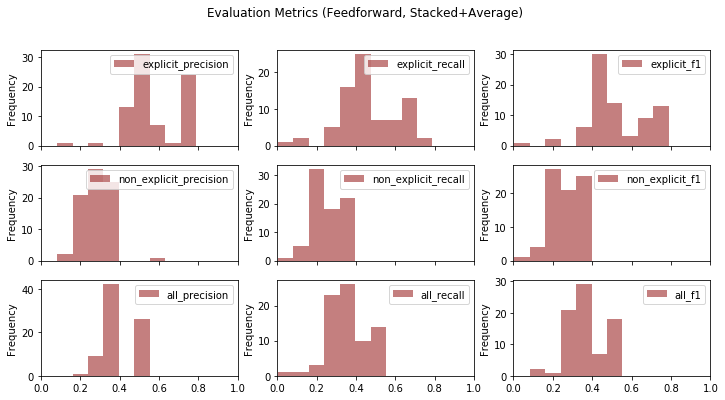

In [337]:
ff_results[['explicit_precision', 'explicit_recall', 'explicit_f1',
            'non_explicit_precision', 'non_explicit_recall', 'non_explicit_f1', 
            'all_precision', 'all_recall', 'all_f1',]].plot(kind='hist', 
                                                           subplots=True,
                                                           color='darkred',
                                                           alpha=0.5, layout=(3,3), xlim=(0,1),
                                                           title='Evaluation Metrics (Feedforward, Stacked+Average)',
                                                           figsize=(12, 6))
plt.savefig('./img/evaluation_metrics_feedforward_all.png')

In [338]:
average_ff_results = ff_results[ff_results.experiment_name.str.startswith('ff_average')]
stacked_ff_results = ff_results[ff_results.experiment_name.str.startswith('ff_stacked')]

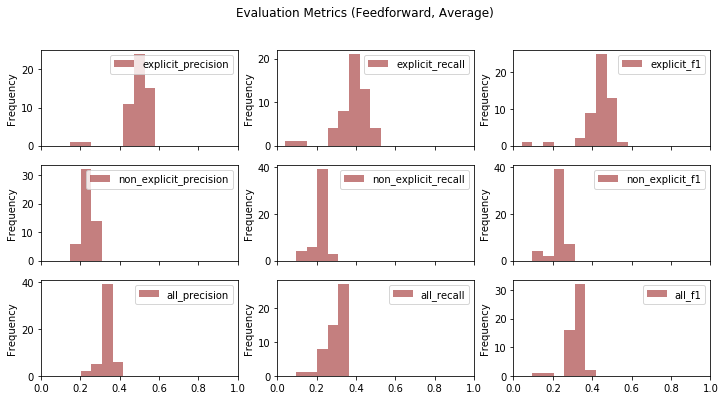

In [339]:
average_ff_results[['explicit_precision', 'explicit_recall', 'explicit_f1',
            'non_explicit_precision', 'non_explicit_recall', 'non_explicit_f1', 
            'all_precision', 'all_recall', 'all_f1',]].plot(kind='hist', 
                                                           subplots=True,
                                                           color='darkred',
                                                           alpha=0.5, layout=(3,3), xlim=(0,1),
                                                           title='Evaluation Metrics (Feedforward, Average)',
                                                           figsize=(12, 6))
plt.savefig('./img/evaluation_metrics_feedforward_average.png')

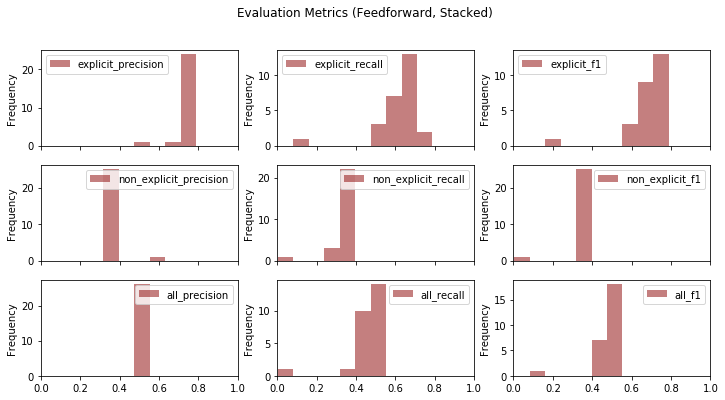

In [340]:
stacked_ff_results[['explicit_precision', 'explicit_recall', 'explicit_f1',
            'non_explicit_precision', 'non_explicit_recall', 'non_explicit_f1', 
            'all_precision', 'all_recall', 'all_f1',]].plot(kind='hist', 
                                                           subplots=True,
                                                           color='darkred',
                                                           alpha=0.5, layout=(3,3), xlim=(0,1),
                                                           title='Evaluation Metrics (Feedforward, Stacked)',
                                                           figsize=(12, 6))
plt.savefig('./img/evaluation_metrics_feedforward_stacked.png')

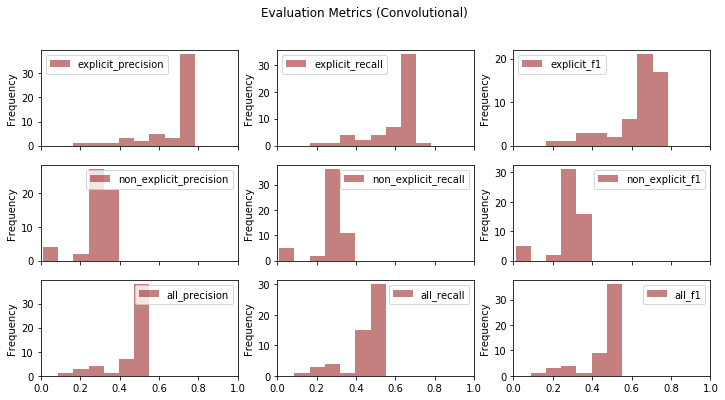

In [341]:
conv_results[['explicit_precision', 'explicit_recall', 'explicit_f1',
              'non_explicit_precision', 'non_explicit_recall', 'non_explicit_f1', 
              'all_precision', 'all_recall', 'all_f1',]].plot(kind='hist', 
                                                           subplots=True,
                                                           color='darkred',
                                                           alpha=0.5, layout=(3,3), xlim=(0,1),
                                                           title='Evaluation Metrics (Convolutional)',
                                                           figsize=(12, 6))
plt.savefig('./img/evaluation_metrics_convolutional.png')

### Observations based on visualizations

- Convolutional seems so much better. 
- However, upon closer inspection it is the `average` features in `feedforward` that are yielding the lower scores
- The last two plots, comparing `feedforward` and `convolutional` on `stacked` features only seem very comparable
- In fact, it seems like `convolutional` even gives a longer left tail for the performance, so it's not obvious that it's better than `feedforward`

### Effect of dropout on All F1

In [342]:
conditions = ff_results.experiment_name
conditions_wo_dropout = conditions.apply(lambda s: re.sub('_dropout0[\.5]*_', '', s))
condition_uses_dropout = conditions.apply(uses_dropout)

In [343]:
dropout_df = pd.DataFrame({
    'condition_wo_dropout': conditions_wo_dropout,
    'uses_dropout': condition_uses_dropout,
    'all_f1': ff_results.all_f1
})

In [344]:
effect_of_dropout = dropout_df\
                    .reset_index()\
                    .drop('index', 1)\
                    .set_index(['condition_wo_dropout', 
                                'uses_dropout'])\
                    .unstack()

In [345]:
dropout_treatment_effect = effect_of_dropout.diff(axis=1)['all_f1'][True]

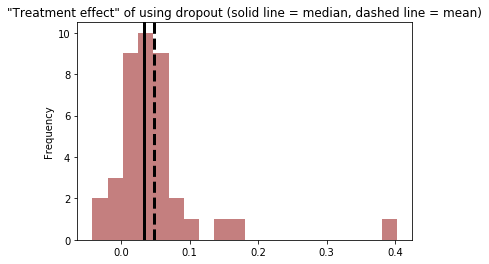

In [346]:
DROPOUT_TREATMENT_EFFECT_TITLE = '"Treatment effect" of using dropout (solid line = median, dashed line = mean)'
ax = dropout_treatment_effect.plot(kind='hist', bins=20,
                                   title=DROPOUT_TREATMENT_EFFECT_TITLE,
                                   color='darkred',
                                   alpha=0.5)
ax.axvline(x=dropout_treatment_effect.mean(), 
           color='black', 
           linestyle='dashed', 
           linewidth=3)

ax.axvline(x=dropout_treatment_effect.median(), 
          color='black', 
          linestyle='solid', 
          linewidth=3)
plt.savefig('./img/ff_dropout_treatment_effect.png')

#### Convolutional dropout

In [347]:
conditions = conv_results.experiment_name
conditions_wo_dropout = conditions.apply(lambda s: re.sub('convdropout0[\.5]*_', '', s))
condition_uses_dropout = conditions.apply(uses_dropout)

In [348]:
dropout_df = pd.DataFrame({
    'condition_wo_dropout': conditions_wo_dropout,
    'uses_dropout': condition_uses_dropout,
    'all_f1': conv_results.all_f1
})

In [349]:
effect_of_dropout = dropout_df\
                    .reset_index()\
                    .drop('index', 1)\
                    .set_index(['condition_wo_dropout', 
                                'uses_dropout'])\
                    .unstack()

In [350]:
dropout_treatment_effect = effect_of_dropout.diff(axis=1)['all_f1'][True]

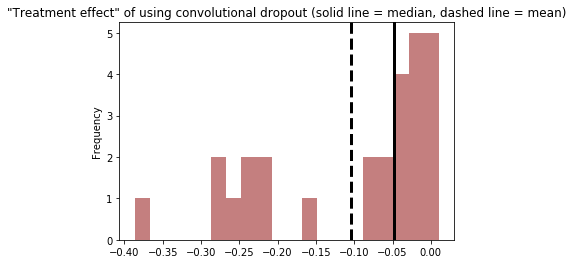

In [351]:
DROPOUT_TREATMENT_EFFECT_TITLE = '"Treatment effect" of using convolutional dropout (solid line = median, dashed line = mean)'
ax = dropout_treatment_effect.plot(kind='hist', bins=20,
                                   title=DROPOUT_TREATMENT_EFFECT_TITLE,
                                   color='darkred',
                                   alpha=0.5)
ax.axvline(x=dropout_treatment_effect.mean(), 
           color='black', 
           linestyle='dashed', 
           linewidth=3)

ax.axvline(x=dropout_treatment_effect.median(), 
          color='black', 
          linestyle='solid', 
          linewidth=3)
plt.savefig('./img/conv_dropout_treatment_effect.png')

### Numbers-based analysis

To make the rather unwieldy data frames better, let's only use the top ones where the `all_f1` and `explicit_f1` exceed 0.5

In [352]:
stacked_ff_results_subset = stacked_ff_results[(stacked_ff_results.all_f1 > 0.5)&(stacked_ff_results.explicit_f1 > 0.5)]

In [353]:
stacked_ff_results.sort_values('all_f1', ascending=False)

experiment_name  dropout  \
56  ff_stacked_padded__dropout0.5_layers_512_256_1...     True   
59  ff_stacked_padded__dropout0.5_layers_512_256_l...     True   
61  ff_stacked_padded__dropout0.5_layers_512_64_12...     True   
71  ff_stacked_padded__dropout0_layers_512_256_64_...    False   
54  ff_stacked_padded__dropout0.5_layers_512_128_6...     True   
55  ff_stacked_padded__dropout0.5_layers_512_128_l...     True   
64  ff_stacked_padded__dropout0.5_layers_512_64_large     True   
73  ff_stacked_padded__dropout0_layers_512_64_128_...    False   
58  ff_stacked_padded__dropout0.5_layers_512_256_6...     True   
57  ff_stacked_padded__dropout0.5_layers_512_256_1...     True   
70  ff_stacked_padded__dropout0_layers_512_256_128...    False   
52  ff_stacked_padded__dropout0.5_layers_512_128_2...     True   
53  ff_stacked_padded__dropout0.5_layers_512_128_2...     True   
69  ff_stacked_padded__dropout0_layers_512_256_128...    False   
77    ff_stacked_padded__dropout0_layers_512_64_large    False   
62  ff_stacked_padded__dropout0.5_layers_512_64_25...     True   
60  ff_stacked_padded__dropout0.5_layers_512_64_12...     True   
63  ff_stacked_padded__dropout0.5_layers_512_64_25...     True   
75  ff_stacked_padded__dropout0_layers_512_64_256_...    False   
67  ff_stacked_padded__dropout0_layers_512_128_64_...    False   
68   ff_stacked_padded__dropout0_layers_512_128_large    False   
74  ff_stacked_padded__dropout0_layers_512_64_128_...    False   
76  ff_stacked_padded__dropout0_layers_512_64_256_...    False   
65  ff_stacked_padded__dropout0_layers_512_128_256...    False   
72   ff_stacked_padded__dropout0_layers_512_256_large    False   
66  ff_stacked_padded__dropout0_layers_512_128_256...    False   

                 layers    layer_condition  all_precision  all_recall  \
56       512_256_128_64             funnel        0.53789    0.509060   
59              512_256             funnel        0.53438    0.508270   
61           512_64_128         bottleneck        0.53595    0.505120   
71           512_256_64             funnel        0.53322    0.505910   
54           512_128_64             funnel        0.53422    0.504330   
55              512_128             funnel        0.53234    0.505910   
64               512_64             funnel        0.52941    0.503550   
73    512_64_128_64_128  double_bottleneck        0.52873    0.500390   
58           512_256_64             funnel        0.52780    0.501180   
57          512_256_128             funnel        0.52829    0.500390   
70          512_256_128             funnel        0.52711    0.498030   
52  512_128_256_128_256  double_bottleneck        0.52623    0.498030   
53          512_128_256         bottleneck        0.52775    0.487000   
69       512_256_128_64             funnel        0.51874    0.479910   
77               512_64             funnel        0.51993    0.472810   
62    512_64_256_64_256  double_bottleneck        0.50553    0.468090   
60    512_64_128_64_128  double_bottleneck        0.49214    0.468870   
63           512_64_256         bottleneck        0.49871    0.457840   
75    512_64_256_64_256  double_bottleneck        0.50313    0.442870   
67           512_128_64             funnel        0.50360    0.441290   
68              512_128             funnel        0.50360    0.441290   
74           512_64_128         bottleneck        0.49774    0.433410   
76           512_64_256         bottleneck        0.49057    0.409770   
65  512_128_256_128_256  double_bottleneck        0.49514    0.401100   
72              512_256             funnel        0.48127    0.394800   
66          512_128_256         bottleneck        0.48684    0.058314   

     all_f1  explicit_precision  explicit_recall  explicit_f1  \
56  0.52308             0.78871          0.71217      0.74849   
59  0.52100             0.78159          0.71217      0.74527   
61  0.52008             0.78493          0.70230      0.74132   
71  0.51921            

In [354]:
conv_results_subset = conv_results[(conv_results.all_f1 > 0.5)&(conv_results.explicit_f1 > 0.5)]

In [355]:
conv_results_subset.sort_values('all_f1', ascending=False)

experiment_name  convolutional_dropout  \
41  conv_stacked_padded__convdropout0_nconv3_filte...                  False   
39  conv_stacked_padded__convdropout0_nconv3_filte...                  False   
44  conv_stacked_padded__convdropout0_nconv3_filte...                  False   
43  conv_stacked_padded__convdropout0_nconv3_filte...                  False   
52  conv_stacked_padded__convdropout0_nconv5_filte...                  False   
46  conv_stacked_padded__convdropout0_nconv5_filte...                  False   
42  conv_stacked_padded__convdropout0_nconv3_filte...                  False   
34  conv_stacked_padded__convdropout0_nconv1_filte...                  False   
45  conv_stacked_padded__convdropout0_nconv5_filte...                  False   
36  conv_stacked_padded__convdropout0_nconv3_filte...                  False   
1   conv_stacked_padded__convdropout0.5_nconv1_fil...                   True   
53  conv_stacked_padded__convdropout0_nconv5_filte...                  False   
47  conv_stacked_padded__convdropout0_nconv5_filte...                  False   
48  conv_stacked_padded__convdropout0_nconv5_filte...                  False   
38  conv_stacked_padded__convdropout0_nconv3_filte...                  False   
4   conv_stacked_padded__convdropout0.5_nconv1_fil...                   True   
30  conv_stacked_padded__convdropout0_nconv1_filte...                  False   

    n_conv_layers             filters  kernel_size   fc_layers  \
41              3          50_150_250            3  512_64_128   
39              3          50_150_250            3  512_128_64   
44              3          50_150_250            4  512_64_128   
43              3          50_150_250            4     512_128   
52              5  50_150_250_350_450            4     512_128   
46              5  50_150_250_350_450            2     512_128   
42              3          50_150_250            4  512_128_64   
34              1                  50            4     512_128   
45              5  50_150_250_350_450            2  512_128_64   
36              3          50_150_250            2  512_128_64   
1               1                  50            2     512_128   
53              5  50_150_250_350_450            4  512_64_128   
47              5  50_150_250_350_450            2  512_64_128   
48              5  50_150_250_350_450            3  512_128_64   
38              3          50_150_250            2  512_64_128   
4               1                  50            3     512_128   
30              1                  50            3  512_128_64   

   fc_layer_condition  all_precision  all_recall   all_f1  explicit_precision  \
41         bottleneck        0.53184     0.50670  0.51897             0.77437   
39             funnel        0.53294     0.50355  0.51783             0.77231   
44         bottleneck        0.53063     0.50512  0.51756             0.78339   
43             funnel        0.52583     0.49724  0.51114             0.78022   
52             funnel        0.52548     0.49567  0.51014             0.76937   
46             funnel        0.52373     0.49567  0.50931             0.75686   
42             funnel        0.52381     0.49409  0.50852             0.76051   
34             funnel        0.51950     0.49330  0.50606             0.78142   
45             funnel        0.51953     0.49251  0.50566             0.74499   
36             funnel        0.51778     0.49330  0.50525             0.74414   
1              funnel        0.51621     0.48936  0.50243             0.74954   
53         bottleneck        0.51447     0.49015  0.50202             0.73561   
47         bottleneck        0.51365     0.48936  0.50121             0.73022   
48             funnel        0.51540     0.48779  0.50121             0.73723   
38         bottleneck        0.51282     0.48857  0.50040             0.74234   
4              funnel        0.51327     0.48779  0.50020             0.74047   
30             funnel        0.

In [357]:
conv_results.groupby('n_conv_layers').all_f1.mean()

n_conv_layers
1    0.484286
3    0.484579
5    0.373697
Name: all_f1, dtype: float64

In [358]:
conv_results.groupby('kernel_size').all_f1.mean()

kernel_size
2    0.441386
3    0.444277
4    0.456899
Name: all_f1, dtype: float64

In [359]:
conv_results.groupby('filters').all_f1.mean()

filters
50                    0.484286
50_150_250            0.484579
50_150_250_350_450    0.373697
Name: all_f1, dtype: float64

In [360]:
conv_results.groupby('fc_layers').all_f1.mean()

fc_layers
512_128       0.466285
512_128_64    0.446941
512_64_128    0.429337
Name: all_f1, dtype: float64

## Analyzing best conv configuration

In [363]:
conv_results_subset[conv_results_subset.experiment_name == 'conv_stacked_padded__convdropout0.5_nconv1_filters50_kernelsize3_fclayers_512_128_large'].loc[4]

experiment_name           conv_stacked_padded__convdropout0.5_nconv1_fil...
convolutional_dropout                                                  True
n_conv_layers                                                             1
filters                                                                  50
kernel_size                                                               3
fc_layers                                                           512_128
fc_layer_condition                                                   funnel
all_precision                                                       0.51327
all_recall                                                          0.48779
all_f1                                                               0.5002
explicit_precision                                                  0.74047
explicit_recall                                                     0.67105
explicit_f1                                                         0.70406
non_explicit

## Analyzing best feedforward configuration

In [365]:
ff_results[ff_results.experiment_name=='ff_stacked_padded__dropout0.5_layers_512_64_large'].loc[64]

experiment_name           ff_stacked_padded__dropout0.5_layers_512_64_large
dropout                                                                True
layers                                                               512_64
layer_condition                                                      funnel
all_precision                                                       0.52941
all_recall                                                          0.50355
all_f1                                                              0.51616
explicit_precision                                                  0.76715
explicit_recall                                                     0.69901
explicit_f1                                                          0.7315
non_explicit_precision                                              0.32772
non_explicit_recall                                                 0.32375
non_explicit_f1                                                     0.32572
Name: 64, dt